# Fernandez et al. (2021)<br />**Bat *Saccopteryx bilineata***

- **Paper:** Fernandez, A. A., Burchardt, L. S., Nagy, M., &amp; Knörnschild, M. (2021). Babbling in a vocal learning bat resembles human infant babbling. <i>Science</i>, <i>373</i>(6557), 923–926. <a href="https://doi.org/10.1126/science.abf9279">https://doi.org/10.1126/science.abf9279</a>
- **Dataset:** Fernandez, Ahana; Burchardt, Lara; Nagy, Martina; Knörnschild, Mirjam (2021), Babbling in a vocal learning bat resembles human infant babbling, Dryad, Dataset, https://doi.org/10.5061/dryad.1c59zw3vg
- **Dataset license:** CC0 1.0 Universal (CC0 1.0) Public Domain Dedication license.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rhythmplot import *

# Or manually define DATADIR = '/path/to/the/dir/with/all/datasets'
from config import DATA_DIR

# Function to save figures: you can easily toggle this on/off globally
savefig = get_figure_saver(group='fernandez2021', save_pdf=False, save_png=False)

## Preprocessing

The normalized pairwise variability index (nPVI) is calculated to assess temporal variance in syllable trains and whether a syllable train is isochronous.	
The nPVI indicates the goodness of predictability from one IOI to the subsequent. The lower the nPVI, the more isochronous is the syllable train.	

For the method see: Burchardt L, Knörnschild M (2020) Comparison of methods for rhythm analysis of complex animals’ acoustic signals. PLoS Comput. Biol. 16, e1007755. doi:10.1371/journal.pcbi.1007755	

N = 30 syllable trains (6 trains per train type) produced by 14 different pups from two populations (Panama, Costa Rica)	
	
Column headings	
- `population`	Panama, Costa Rica
- `pup ID`	Identification numbers of pups
- `recording date`	year_month_day
- `syllable train type`	affiliative, aggressive, neutral, IC, UPS (see supplementary material for definitions)
- `label`	position of syllable in sequence
- `duration` [s]	duration of each syllable from start to end
- `start time`	time stamp of syllable onset
- `end time`	time stamp of syllable offset
- `IOI`	inter-onset-interval (time between the start of one syllable and the start of the next syllable)
- `nPVI`	normalized Pairwise Variability Index

In [50]:
columns = [
    'population',
    'pup_id', 
    'recording_date', 
    'syllable_train_type',
    'syllable_position', # was label 
    'syllable_duration',
    'syllable_start',
    'syllable_end',
    'syllable_ioi'
] 

In [52]:
df = pd.read_csv(f'{DATA_DIR}/fernandez2021/IOI.csv', delimiter=';', decimal=",",  header=[0,1])
df.columns = columns
sequences = []
cur_seq = 0
for _, pos in df['syllable_position'].items():
    if pos == 1:
        cur_seq += 1
    sequences.append(cur_seq)
df['sequence'] = sequences
# df.to_csv('intervals/fernandez2021/fernandez2021-data.csv', index=False)

In [53]:
intervals = []
for _, (pos, ioi) in df[['syllable_position', 'syllable_ioi']].iterrows():
    if pos == 1:
        intervals.append(np.nan)
    intervals.append(ioi)
intervals= np.array(intervals[1:])
# save_intervals(intervals, 'fernandez2021', 'fernandez2021')

## Plot

In [54]:
intervals = load_intervals('fernandez2021', 'fernandez2021')
df = pd.read_csv('intervals/fernandez2021/fernandez2021-data.csv')

Note: to store the figure, enable save_pdf or save_png in get_figure_saver.


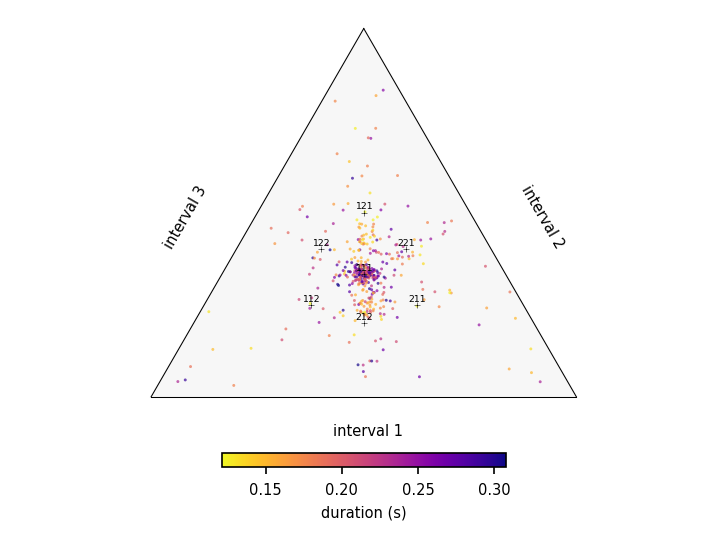

In [9]:
motifs, duration = normalize(ngram_motifs(intervals, length=3))
ternary_motif_plot(motifs, duration, scatter_kws=dict(s=2, alpha=.7), ratio_kws=dict(factors=[1,2]))
savefig('motifs')

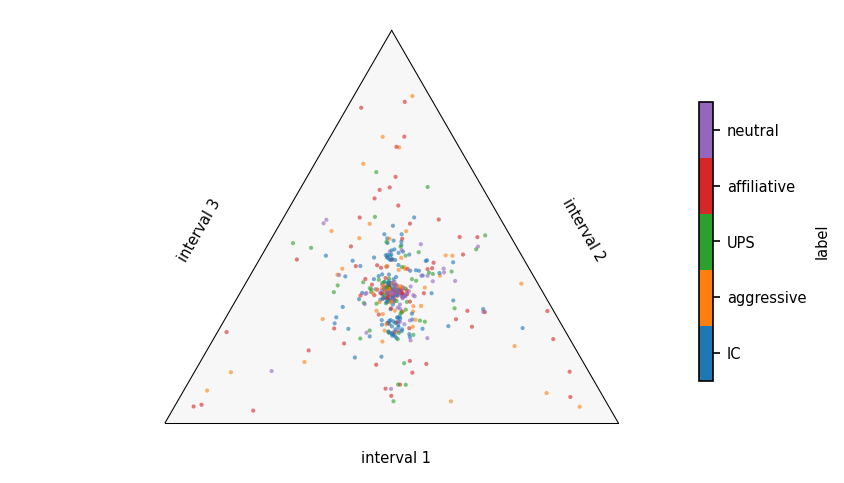

In [7]:
types = [ 'neutral', 'affiliative', 'UPS', 'aggressive', 'IC']
subset = separate_sequences(df[df['syllable_train_type'].isin(types)])

# Get rhythm motifs
intervals = subset['syllable_ioi'].values
motifs, duration = normalize(ngram_motifs(intervals, length=3))

# Determine labels
# Ignore columns where ioi is missing, but train type is not (i.e., last syll in a seq)
mismatch = subset['syllable_ioi'].isna() & (~subset['syllable_train_type'].isna())
train_types = subset[~mismatch]['syllable_train_type'].values
# All motifs in a sequence have the same type, so we just pick the first
labels = string_motifs(train_types, 3, aggregator=lambda motif: motif[0])

ternary_motif_plot(motifs, duration, labels=labels, 
    scatter_kws=dict(s=4, alpha=.6), ratios=False, ratio_kws=dict(factors=[1,2]))

savefig('by-syllable-train-type')

# Anisochrony

ImportError: cannot import name 'integer_ratio_motifs' from 'rhythmplot.motifs' (/Users/Bas/repos/posts/rhythm-plots/rhythmplot/motifs.py)

In [305]:
def irrationality(motifs, factors=[1, 2, 3]):
    refs, _ = integer_ratio_motifs(factors, motifs.shape[1])
    distances = np.zeros((motifs.shape[0], len(refs)))
    for i, reference in enumerate(refs):
        diff = motifs - reference[np.newaxis, :]
        dist = np.linalg.norm(diff, ord=2, axis=1)
        distances[:, i] = dist
    return distances.min(axis=1)

motifs, _ = normalize(np.array([[5, 1], [1, 1]]))
irrationality(motifs, factors = [1,2])

array([0.23570226, 0.        ])

In [244]:
for t in types:
    subset = df.query(f'syllable_train_type=="{t}"')
    ints = subset['syllable_ioi'].dropna().values
    print(t, npvi(ints), orig_nPVI(ints))#MA(ints, 3), MA(ints, 4), MA(ints, 5))

neutral 22.29899318955039 22.29899318955039
affiliative 53.50744146807802 53.50744146807802
UPS 27.337568939777302 27.337568939777302
aggressive 43.295051262783275 43.295051262783275
IC 35.23519719049737 35.23519719049736


In [221]:
def ratios_to_intervals(ratios, start=1):
    intervals = [start]
    for r in ratios:
        prev_int = intervals[-1]
        next_int = prev_int * (1 - r) / r
        intervals.append(next_int)
    return np.array(intervals)

ratios = np.random.random(size=50)
ints = ratios_to_intervals(ratios)

(<Figure size 900x600 with 2 Axes>,
 TernaryAxesSubplot: 291266081,
 <matplotlib.colorbar.Colorbar at 0x115dad8d0>)

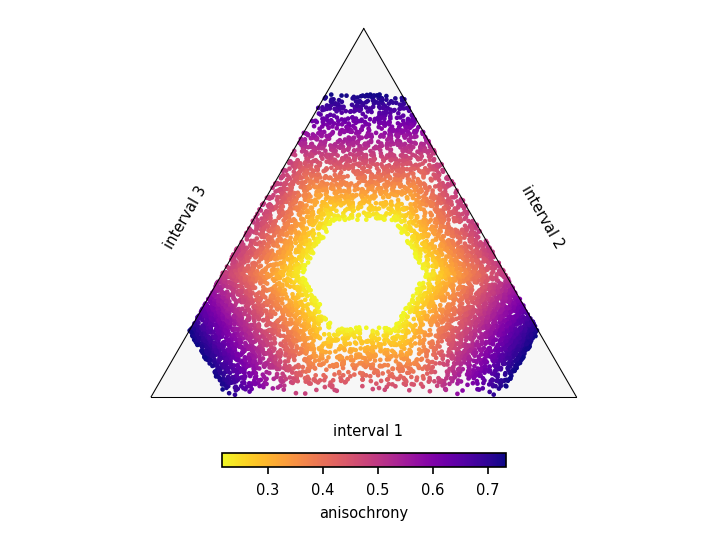

In [229]:
# intervals = np.random.random(size=1000)
ratios = np.random.random(size=10000)
ints = ratios_to_intervals(ratios)
motifs, duration = normalize(ngram_motifs(ints, length=3))
alphas = anisochrony(motifs)
ternary_motif_plot(motifs, alphas, 
    scatter_kws=dict(s=5, alpha=1), cbar_kws=dict(label='anisochrony'),
    ratios=False)

(<Figure size 900x600 with 2 Axes>,
 TernaryAxesSubplot: 275391669,
 <matplotlib.colorbar.Colorbar at 0x115c4e410>)

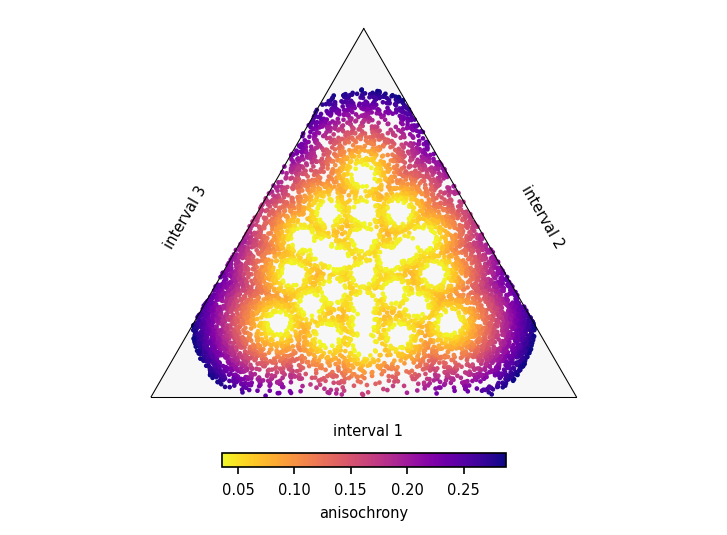

In [306]:
# intervals = np.random.random(size=1000)
ratios = np.random.random(size=10000)
ints = ratios_to_intervals(ratios)
motifs, duration = normalize(ngram_motifs(ints, length=3))
alphas = irrationality(motifs)
ternary_motif_plot(motifs, alphas, 
    scatter_kws=dict(s=5, alpha=1), cbar_kws=dict(label='anisochrony'),
    ratios=False)

array([[ 1.,  0., -0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])

(<Figure size 1350x525 with 6 Axes>,
 TernaryAxesSubplot: 301647137,
 <matplotlib.colorbar.Colorbar at 0x120df7450>)

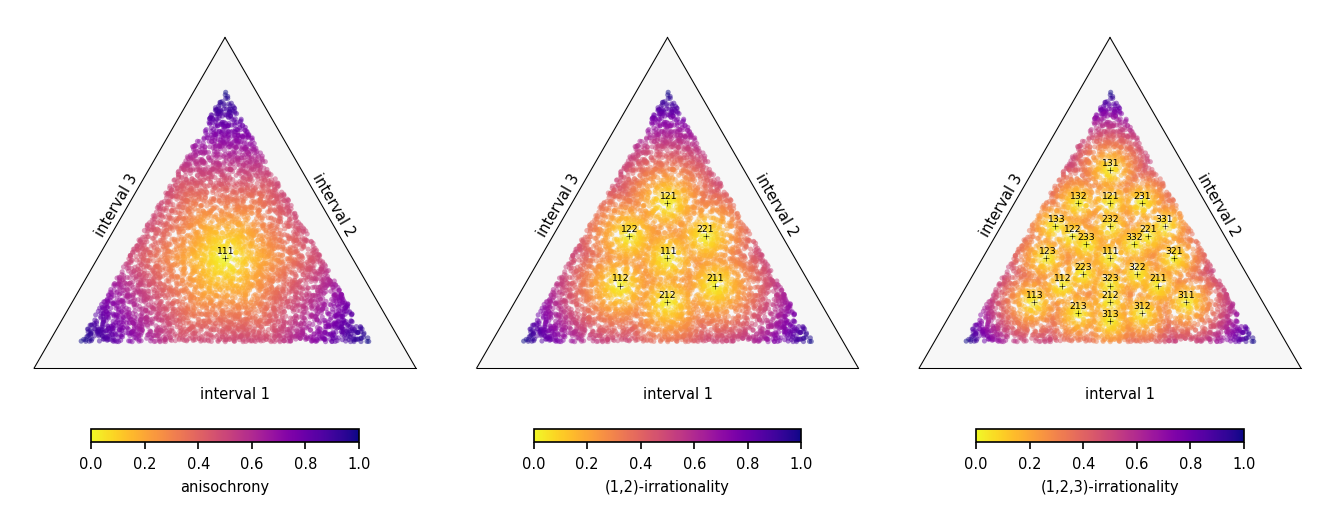

In [547]:
samples = uniform_subsample_triangle(20000, margin=.08)

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(9, 3.5), tight_layout=True)
kws = dict(min_dur=0, max_dur=2, scatter_kws=dict(s=6, alpha=.5), cmap='plasma_r', plot_kws=dict(bottom_label_offset=-.1))
ternary_motif_plot(samples, np.ones(len(samples)), 
    c=anisochrony(samples), 
    ratio_kws=dict(factors=[1]),
    cbar_kws=dict(label='anisochrony'), 
    ax=ax0, **kws)

ternary_motif_plot(samples, np.ones(len(samples)), 
    c=irrationality(samples, factors=[1, 2]), 
    ratio_kws=dict(factors=[1, 2]),
    cbar_kws=dict(label='(1,2)-irrationality'), 
    ax=ax1, **kws)

ternary_motif_plot(samples, np.ones(len(samples)), 
    c=irrationality(samples, factors=[1, 2, 3]), 
    ratio_kws=dict(factors=[1, 2, 3]),
    cbar_kws=dict(label='(1,2,3)-irrationality'), 
    ax=ax2, **kws)

In [ ]:
def  xy2bc(xy):
    corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
    (x1, y1), (x2, y2), (x3, y3) = corners
    T = np.array([[x1 - x3, x2 - x3], [y1 - y3, y2 - y3]])
    T_inv = np.linalg.inv(T)
    return np.linalg.inv(T).dot(x - corners[-1])

In [335]:
def xy2bc(xy):
    corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
    mat = np.r_[[[1, 1, 1]], corners.T]
    return np.linalg.inv(mat).dot([1, xy[0], xy[1]])

In [338]:
xy2bc([0, 1])

array([ 0.42264973, -0.57735027,  1.15470054])

In [314]:
T = np.array([[x1 - x3, x2 - x3], [y1 - y3, y2 - y3]])
x = np.array([.2, .3])
np.linalg.inv(T).dot(x - corners[-1])

array([0.62679492, 0.02679492])

In [ ]:
import matplotlib.tri as tri

corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
triangle = tri.Triangulation(corners[:, 0], corners[:, 1])
_midpoints = [(_corners[(i + 1) % 3] + corners[(i + 2) % 3]) / 2.0 \
              for i in range(3)]

def xy2bc(xy, tol=1.e-3):
    '''Converts 2D Cartesian coordinates to barycentric.
    Arguments:
        `xy`: A length-2 sequence containing the x and y value.
    '''
    s = [(_corners[i] - _midpoints[i]).dot(xy - _midpoints[i]) / 0.75 \
         for i in range(3)]
    return np.clip(s, tol, 1.0 - tol)

(<Figure size 900x600 with 2 Axes>,
 TernaryAxesSubplot: 288649753,
 <matplotlib.colorbar.Colorbar at 0x1056e4910>)

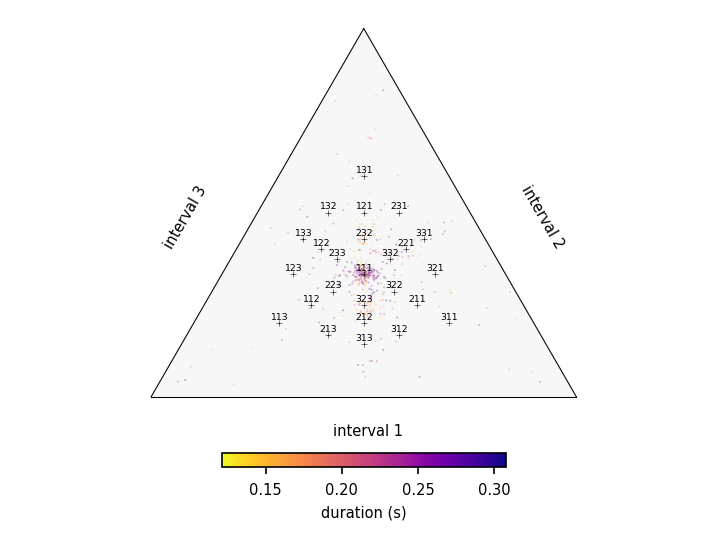

In [176]:
intervals = load_intervals('fernandez2021', 'fernandez2021')
motifs, duration = normalize(ngram_motifs(intervals, length=3))


In [ ]:
types = [ 'neutral', 'affiliative', 'UPS', 'aggressive', 'IC']
subset = separate_sequences(df[df['syllable_train_type'].isin(types)])

# Get rhythm motifs
intervals = subset['syllable_ioi'].values
motifs, duration = normalize(ngram_motifs(intervals, length=3))abs

(0.0, 1.0, 0.0, 1.0)

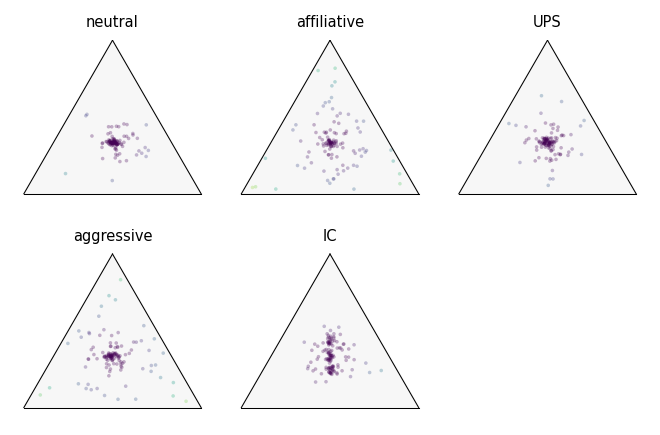

In [240]:
types = [ 'neutral', 'affiliative', 'UPS', 'aggressive', 'IC']
fig, axs = plt.subplots(2, 3, figsize=(4.5, 3), tight_layout=True)
for i, t in enumerate(types):
    subset = separate_sequences(df[df['syllable_train_type'] == t])

    # Get rhythm motifs
    intervals = subset['syllable_ioi'].values
    motifs, duration = normalize(ngram_motifs(intervals, length=3))
    alphas = anisochrony(motifs)

    # Determine labels
    # Ignore columns where ioi is missing, but train type is not (i.e., last syll in a seq)
    mismatch = subset['syllable_ioi'].isna() & (~subset['syllable_train_type'].isna())
    train_types = subset[~mismatch]['syllable_train_type'].values
    # All motifs in a sequence have the same type, so we just pick the first
    labels = string_motifs(train_types, 3, aggregator=lambda motif: motif[0])
    from matplotlib.colors import Normalize
    ternary_motif_plot(motifs, duration, c=alphas, 
        dur_quantile=(0,1),
        norm=Normalize(.2, 1), cmap='viridis',
        scatter_kws=dict(s=3, alpha=.3), ratios=False, cbar=False,
        plot_kws=dict(labels=False), ax = axs.ravel()[i])
    axs.ravel()[i].set_title(t, fontsize=7)

axs[-1, -1].axis('off')

### Combined

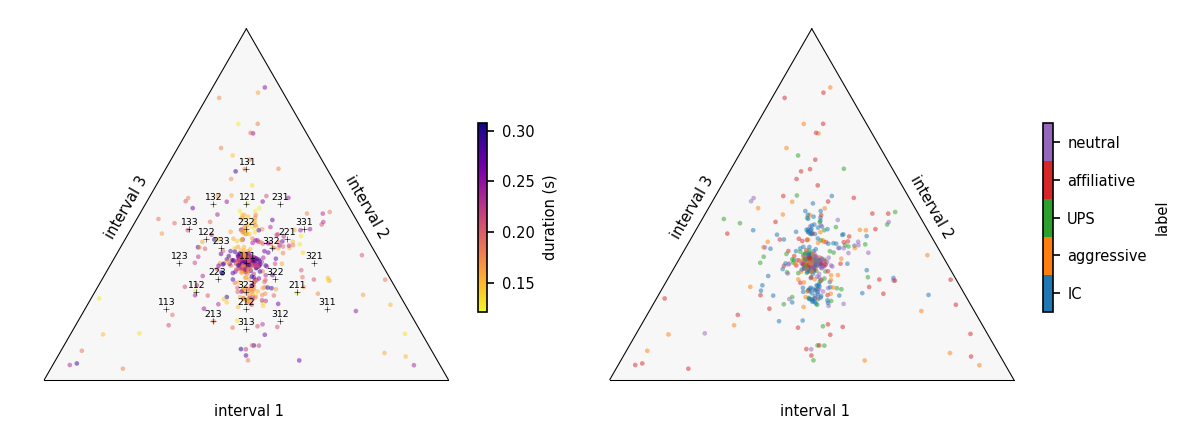

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3), tight_layout=True)

kws = dict(
    scatter_kws=dict(s=5, alpha=.5), 
    cbar_kws=dict(orientation='vertical', pad=0, fraction=0.02)
)

# Plot, colored by duration
intervals = load_intervals('fernandez2021', 'fernandez2021')
motifs, duration = normalize(ngram_motifs(intervals, length=3))
ternary_motif_plot(motifs, duration, ax=ax1, **kws)

# Plot colored by category
types = [ 'neutral', 'affiliative', 'UPS', 'aggressive', 'IC']
subset = separate_sequences(df[df['syllable_train_type'].isin(types)])

# Get rhythm motifs
intervals = subset['syllable_ioi'].values
motifs, duration = normalize(ngram_motifs(intervals, length=3))

# Determine labels
# Ignore columns where ioi is missing, but train type is not (i.e., last syll in a seq)
mismatch = subset['syllable_ioi'].isna() & (~subset['syllable_train_type'].isna())
train_types = subset[~mismatch]['syllable_train_type'].values
# All motifs in a sequence have the same type, so we just pick the first
labels = string_motifs(train_types, 3, aggregator=lambda motif: motif[0])

ternary_motif_plot(motifs, duration, labels=labels, 
    ratios=False, ratio_kws=dict(factors=[1,2]), ax=ax2, 
    **kws)

savefig('overview')